# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [902]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.94898581558364

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [903]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.930440263418237

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [904]:
from matplotlib import pyplot as plt
%matplotlib inline

In [905]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [906]:
x = np.random.exponential(size=sample_size)
noise = np.random.uniform(low=-1, high=1, size=sample_size)
y = f(x) + noise

In [907]:
tree = DecisionTreeRegressor()
tree.fit(x.reshape(x.shape[0],-1), y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [908]:
pred = tree.predict(linspace.reshape(linspace.shape[0], -1))

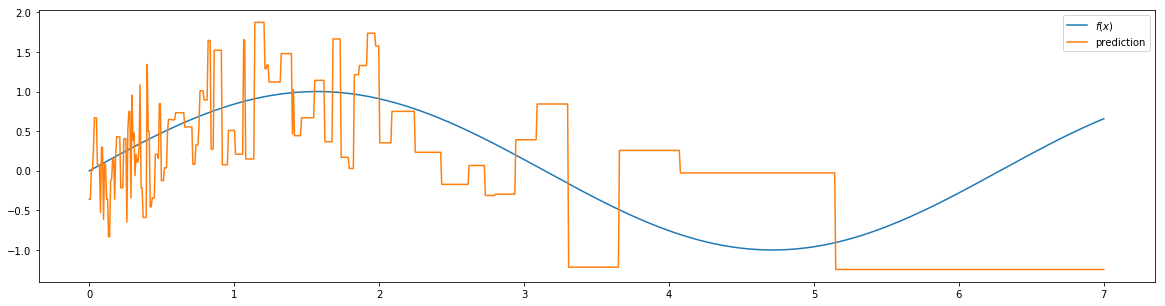

In [909]:
plt.figure(figsize=(20,5))
plt.plot(linspace, f(linspace), label='$f(x)$')
plt.plot(linspace, pred, label='prediction')

plt.legend();

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

In [910]:
def experiment(estimator, title):

    plt.figure(figsize=(20,5))
    pred_lst = []

    for i in range(samples_num):
        x = np.random.exponential(size=sample_size)
        noise = np.random.uniform(low=-1, high=1, size=sample_size)
        y = f(x) + noise
        
        model = estimator
        model.fit(x.reshape(x.shape[0],-1), y)
        pred = model.predict(linspace.reshape(linspace.shape[0], -1))
        pred_lst.append(pred)
        plt.plot(linspace, pred, color='gray', alpha=0.5)

    plt.plot(linspace, f(linspace), color='red', label='$f(x)$')
    plt.plot(linspace, np.asarray(pred_lst).mean(axis=0), color='black', label='meaan prediction')
    plt.legend()
    plt.title(title);

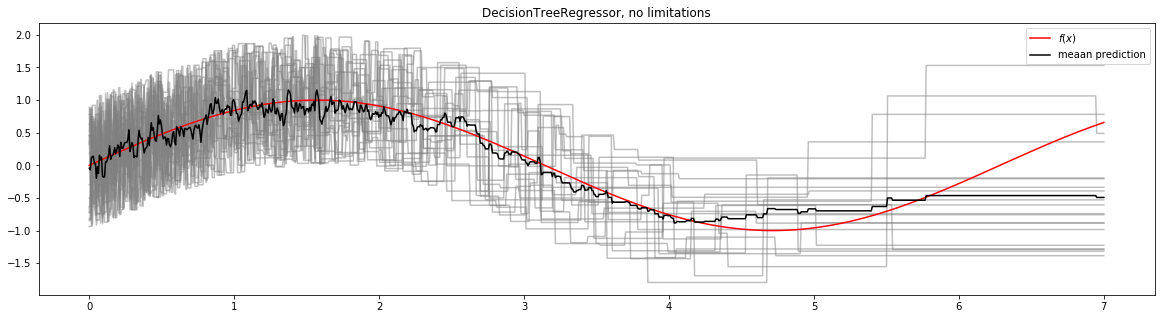

In [911]:
experiment(DecisionTreeRegressor(), 'DecisionTreeRegressor, no limitations')

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

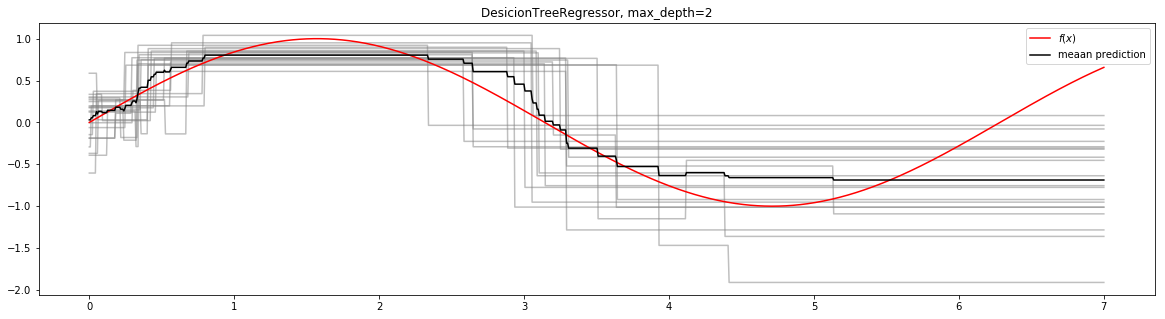

In [912]:
experiment(DecisionTreeRegressor(max_depth=2), 'DesicionTreeRegressor, max_depth=2')

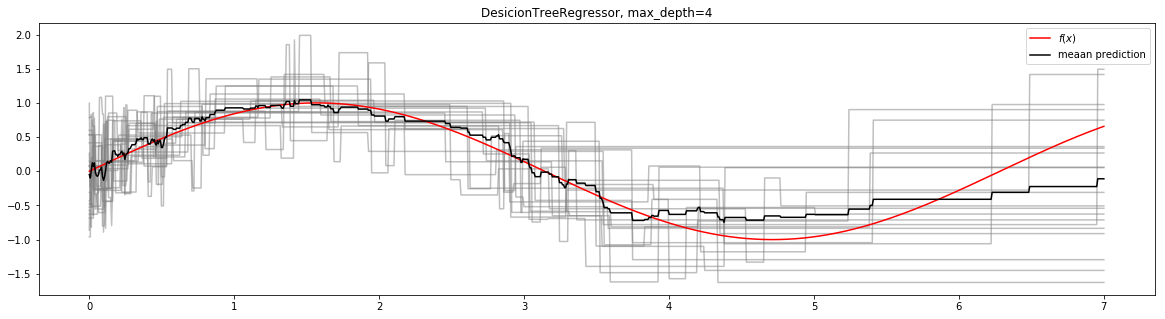

In [913]:
experiment(DecisionTreeRegressor(max_depth=4), 'DesicionTreeRegressor, max_depth=4')

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Смещение показывает, насколько данный алгоритм отличается от идеального. Прогнозы решающего дерева – "ступени", их число зависит от глубины дерева. Так что чем оно глубже, тем лучше оно должно приближать исходную функцию. 

Так и вышло: смещение получается наименьшим в модели без ограничений на глубину. Однако даже там оно не может быть нулевым, поскольку прогнозируемая функция гладкая.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

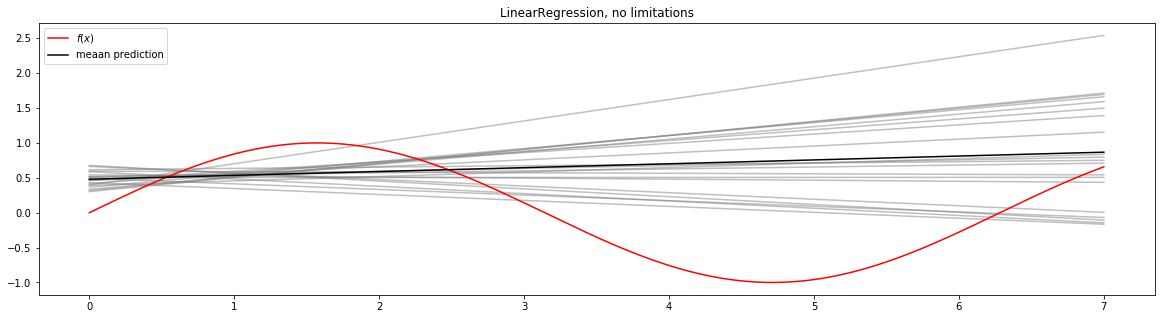

In [914]:
experiment(LinearRegression(), 'LinearRegression, no limitations')

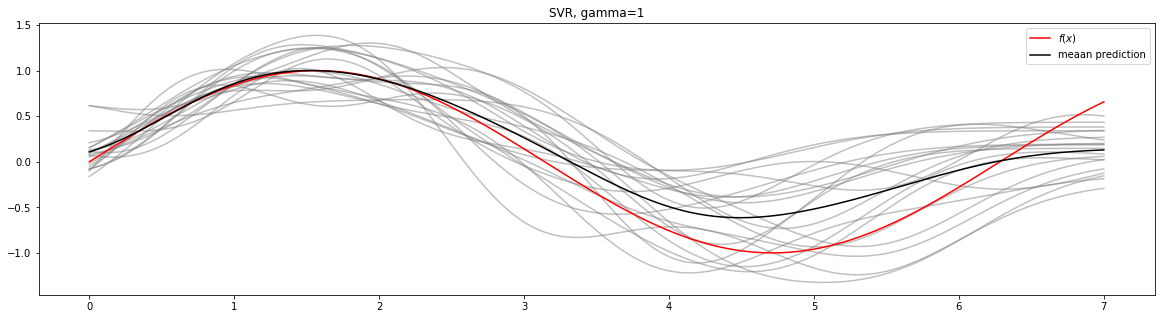

In [915]:
experiment(SVR(gamma=1), 'SVR, gamma=1')

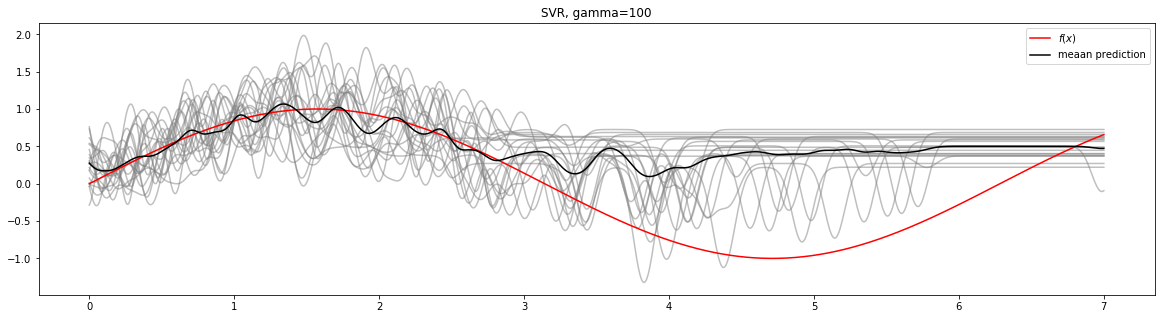

In [916]:
experiment(SVR(gamma=100), 'SVR, gamma=100')

Очевидно, что предсказывать нелинейную функцию линейной регрессия – плохая идея. Этот алгоритм не способен поймать необходимую зависимость, поэтому смещение всегда будет крайне большим.

SVR с $\gamma=1$ даёт наиболее близкий к истине результат, хотя смещение всё же остаётся.

Вид прогноза у SVR с $\gamma=100$ свидетельствует о переобучении: усреднённые предсказания имеют довольно сложный вид и не улавливают форму прогнозируемой кривой.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [86]:
pd.options.display.max_columns = 100

mushrooms = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data', 
                        header=None)
tic = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data', 
                 header=None)
cars = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data', 
                   header=None)
nursery = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data',
                     header=None)

In [87]:
# отделим целевые переменные

y_mushrooms = mushrooms.loc[:,0]
mushrooms.drop(0, axis=1, inplace=True)

y_tic = tic.loc[:, 9]
tic.drop(9, axis=1, inplace=True)

y_cars = cars.loc[:, 6]
y_cars[y_cars.isin(['unacc', 'acc'])] = 0
y_cars[y_cars.isin(['good', 'vgood'])] = 1
cars.drop(6, axis=1, inplace=True)

y_nursery = nursery.loc[:, 8]
y_nursery[y_nursery.isin(['not_recom', 'recommend'])] = 0
y_nursery[y_nursery.isin(['very_recom', 'priority', 'spec_prior'])] = 1
nursery.drop(8, axis=1, inplace=True)

In [88]:
def label_enc(df):
    lbl = LabelEncoder()
    for col in df.columns:
        df.loc[:, col] = lbl.fit_transform(df[col])
    return

In [89]:
label_enc(mushrooms)
label_enc(tic)
label_enc(cars)
label_enc(nursery)

In [90]:
y_cars = y_cars.astype('int')
y_nursery = y_nursery.astype('int')

Поскольку во всех датасетах (кроме mushrooms) классы несбалансированы (это указано в описании и подтверждается с помощью `value_counts()`), а данные `tic` и `cars`  кажутся отсортированными при беглом просмотре, сначала перемашаем выборки:

In [91]:
mushrooms, y_mushrooms = shuffle(mushrooms, y_mushrooms, random_state=10)
tic, y_tic = shuffle(tic, y_tic, random_state=10)
cars, y_cars = shuffle(cars, y_cars, random_state=10)
nursery, y_nursery = shuffle(nursery, y_nursery, random_state=10)

In [92]:
def trees_val(X, y, df_name):
    clf = DecisionTreeClassifier()
    cv = cross_val_score(clf, X, y, scoring='accuracy', cv=10)
    print('df: {0}; cv_mean acuracy: {1:.5}'.format(df_name, np.mean(cv)))
    return 

Все категориальные - делаем OneHotEncding на результатах LabelEncoder:

In [93]:
ohe = OneHotEncoder()

mushrooms_ohe = ohe.fit_transform(mushrooms).toarray()
tic_ohe = ohe.fit_transform(tic).toarray()
cars_ohe = ohe.fit_transform(cars).toarray()
nursery_ohe = ohe.fit_transform(nursery).toarray()

In [94]:
trees_val(mushrooms_ohe, y_mushrooms, 'mushrooms')
trees_val(tic_ohe, y_tic, 'tic')
trees_val(cars_ohe, y_cars, 'cars')
trees_val(nursery_ohe, y_nursery, 'nursery')

df: mushrooms; cv_mean acuracy: 1.0
df: tic; cv_mean acuracy: 0.94041
df: cars; cv_mean acuracy: 0.98609
df: nursery; cv_mean acuracy: 0.99977


Все вещественные:

In [95]:
trees_val(mushrooms.astype('float'), y_mushrooms, 'mushrooms')
trees_val(tic.astype('float'), y_tic, 'tic-rac-toe')
trees_val(cars.astype('float'), y_cars, 'cars')
trees_val(nursery.astype('float'), y_nursery, 'nursery')

df: mushrooms; cv_mean acuracy: 1.0
df: tic-rac-toe; cv_mean acuracy: 0.87464
df: cars; cv_mean acuracy: 0.99131
df: nursery; cv_mean acuracy: 0.99969


Корректное разбиение (ординальые переменные считаем вещественными):

В датасете `mushrooms` все признаки категориальные и не упорядоченные, так что для него корректное разбиение было представлено в первом случае. 

То же самое верно для датасета `tic-tac-toe`.

В оставшихся датасетах над всеми признаками определён порядок, так что вообще для них корректен предыдущий случай. Но попробуем считать вещественными только признаки типа "1, 2, 3, 4, 5 и больше", а остальные – категориальными.

In [96]:
cars.loc[:, 2:3] = cars.loc[:, 2:3].astype('float')
nursery.loc[:, 3] = nursery.loc[:, 3].astype('float')

In [97]:
cars.loc[:, :1] = cars.loc[:, :1].apply(lambda x: x.astype('category'))
cars.loc[:, 4:] = cars.loc[:, 4:].apply(lambda x: x.astype('category'))
nursery.loc[:, :2] = nursery.loc[:, :2].apply(lambda x: x.astype('category'))
nursery.loc[:, 4:] = nursery.loc[:, 4:].apply(lambda x: x.astype('category'))

In [98]:
trees_val(cars, y_cars, 'cars')
trees_val(nursery, y_nursery, 'nursery')

df: cars; cv_mean acuracy: 0.98899
df: nursery; cv_mean acuracy: 0.99969


__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

Алгоритмы ранжиуруются по-разному. Так, для `mushrooms` результаты стабильно одинаковы. Возможно, данные слишком просты для дерева.

Для `tic-tac-toe` корректное разбиение на категориальные признаки дало наилучший результат.

Для `cars` лучший результат при разбиении на все вещественные, что логично, потому что все признаки в этом датасете являются упорядоченными.

Для `nursery` все три результата крайне близки.

Про случайность: изначально данные были упорядочены, а в `cross_val_score` нет парметра `shuffle`, видимо, сам он не мешает, поэтому это могло бы повлиять на результат. К случайности ещё можно отнести различие результатов при перезапуске ячеек, так как в самом алгоритме заложена случайность при разбиениях.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [929]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [930]:
df = shuffle(df, random_state=10)

In [931]:
X = df.loc[:,'fixed acidity':'alcohol']
y = df.loc[:,'quality']

In [932]:
print('DecisionTreeClassifier: {:.3}'.format(np.mean(cross_val_score(DecisionTreeClassifier(), 
                                                                     X, y, scoring='accuracy'))))
print('BagginfClassifier: {:.3}'.format(np.mean(cross_val_score(BaggingClassifier(n_estimators=100), 
                                                                X, y, scoring='accuracy'))))
print('BagginfClassifier: {:.3}'.format(np.mean(cross_val_score(BaggingClassifier(n_estimators=100, 
                                                                                  max_features=0.5), 
                                                                X, y, scoring='accuracy'))))
print('RandomForest: {:.3}'.format(np.mean(cross_val_score(RandomForestClassifier(n_estimators=100), 
                                                                X, y, scoring='accuracy'))))

DecisionTreeClassifier: 0.59
BagginfClassifier: 0.663
BagginfClassifier: 0.671
RandomForest: 0.672


#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [939]:
X_shuffled, y_shuffled = shuffle(X, y, random_state=10)

X_train, X_test, y_train, y_test = train_test_split(X_shuffled, y_shuffled, test_size=0.3)

In [940]:
clf = RandomForestClassifier(n_estimators=100, warm_start=True, random_state=10)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=10,
            verbose=0, warm_start=True)

In [941]:
accuracy = [accuracy_score(y_test, clf.predict(X_test))]

In [942]:
for i in range(200, 5001, 100):
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)
    accuracy.append(accuracy_score(y_test, clf.predict(X_test)))

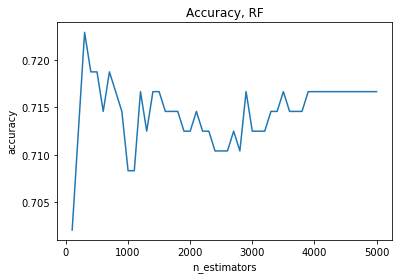

In [943]:
plt.plot(np.arange(100, 5001, 100), accuracy)
plt.title('Accuracy, RF')
plt.xlabel('n_estimators')
plt.ylabel('accuracy');

In [944]:
np.arange(100, 5001, 100)[accuracy.index(np.max(accuracy))]

300

Наибольшая доля правильных ответов достигается при `n_estimators = 300`. Затем качество довольно волатильно, но в конуе становится все более стабильным. Поскольку при большом числе деревьев качество несильно ниже, чем при оптимальном, то эффект переобучения не слишком высок.

Также замечу, что резульаты сильно варьируются при перезапуске ячеек, но в целом паттерн сохраняется: переобучение с ростом числа деревьев растёт несильно

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

In [945]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping

(x_train, y_train), (x_test, y_test) = mnist.load_data()

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [946]:
x_train = x_train.reshape(x_train.shape[0], -1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32')
x_train /= 255
x_test /= 255
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [947]:
x_train.shape

(60000, 784)

In [948]:
model = Sequential()
model.add(Dense(100, input_dim=784, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [949]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [950]:
model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s - loss: 0.2417 - acc: 0.9294 - val_loss: 0.1314 - val_acc: 0.9604

Итоговое качество на тесте составило около $0.975$

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [951]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

In [952]:
earlystopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=1,
                              verbose=0, mode='auto')

In [953]:
model = Sequential()
 
model.add(Convolution2D(32, (6, 6), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
 
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [954]:
model.fit(x_train, y_train, epochs=7, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 84s - loss: 0.1342 - acc: 0.9585 - val_loss: 0.0507 - val_acc: 0.9843

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [899]:
model = Sequential()
 
model.add(Convolution2D(32, (6, 6), activation='relu', input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [900]:
model.fit(x_train, y_train, epochs=7, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/7
60000/60000 [==============================] - 77s - loss: 0.1809 - acc: 0.9445 - val_loss: 0.0540 - val_acc: 0.9805

В итоге удалось добиться большего качества.

Отличие – при добавлении dropout-слоёв, loss становится выше, accuracy ниже на обучени, но выше на контроле. Это ожидаемый результат, так как dropout обычно используется с целью борьбы с переобучением.